# mcmc-within-Gibbs for deblurring

In [15]:
from utils import PSNR,DateSet, numpy2gpu,load_split_data
from utils import gen_tests_of_deblur,x_post_sample_modify,prior_mean_cov
from utils import sample_cumulated_sum
from solvers import  get_x_ml
from visualize import printdict
%matplotlib inline
# %load_ext autoreload   # 自动重新导入最新的外部文件
# %autoreload 2

In [2]:
%run problem_setting.py

        image_size: 64
noise_signal_ratio: 0.02
M_samples_per_para: 100
          mu_range: [0.4, 0.6]
           mu_nums: 20
       gamma_range: [0.1, 0.3]
        gamma_nums: 20
           d_range: [0.10416666666666667, 0.25]
            d_nums: 50
            t_in_G: 0.04
            r_in_G: 4
                 G: (4096, 4096)
             distM: (4096, 4096)
  data_file_prefix: data/deblur_size64_mu20_0.4_0.6_gamma20_0.1_0.3_d50_0.1042_0.25_M100
          data_dim: 4096
             x_dim: 4096
---------------------------------------------------------------------------
number of samples: 20000*  100  (mu_nums*gamma_nums*d_nums*M_samples_per_para)
---------------------------------------------------------------------------


# load model and simulate test data 

In [3]:
model_file_name = 'cave_deblur_size64_epoch10_8_30' #??

args = np.load(os.path.join('saved_model',model_file_name)+"_args.npy",allow_pickle=True).item()
hypers = np.load(os.path.join('saved_model',model_file_name)+"_hypers.npy",allow_pickle=True).item()

print(model_file_name)
printdict(args),printdict(hypers)

cvae = torch.load(os.path.join('saved_model',model_file_name)+".pth")

cave_deblur_size64_epoch10_8_30
            epochs: 10
        batch_size: 256
encoder_layer_sizes: [8195, 100, 200, 400, 800, 1600]
decoder_layer_sizes: [1600, 800, 400, 100, 3]
       latent_size: 10
       print_every: 5000
          fig_root: figs
       conditional: True
        image_size: 64
noise_signal_ratio: 0.02
M_samples_per_para: 100
          mu_range: [0.4, 0.6]
           mu_nums: 20
       gamma_range: [0.1, 0.3]
        gamma_nums: 20
           d_range: [0.10416666666666667, 0.25]
            d_nums: 50
            t_in_G: 0.04
            r_in_G: 4
                 G: (4096, 4096)
             distM: (4096, 4096)
  data_file_prefix: data/deblur_size64_mu20_0.4_0.6_gamma20_0.1_0.3_d50_0.1042_0.25_M100
          data_dim: 4096
             x_dim: 4096


(None, None)

真实theta不知道，所以初始点也不好取;  那么可以考虑初始采样从x开始，x取$\max p(y|x) $ 或者 $\max p(x|y)$都可以

In [4]:
def Gibbs_sample(N,use_sample_size,x_truth,y,T_obs_inv,hypers,show_step=200,theta_truth=None):
    #     x_0 = get_x_map(y_truth,T_pr_truth,T_obs_inv,mus,hypers)   # 错误。原因是mus,T_pr_truth是真实超参数得到的变量，不能用的
    G = hypers['G']
    H,GTy = G.T@T_obs_inv@G, G.T@T_obs_inv@y #args of x_post_sample_modify

    x_0 =  get_x_ml(y,T_obs_inv,hypers)
    x_init_value = x_0
    
    x_sum,x_square_sum = np.zeros_like(x_truth),np.zeros_like(x_truth)
    theta_sum,theta_square_sum = np.zeros_like(theta_truth),np.zeros_like(theta_truth)  
    
    for i in tqdm(range(N)):
        # sample theta
        c = torch.cat((torch.tensor(x_0).float(),torch.tensor(y).float()),dim=0).T.to(device)
        z = torch.randn([c.size(0), args['latent_size']]).to(device)
        theta_0_gpu = cvae.inference(z, c=c)
        theta_0 = theta_0_gpu.detach().cpu().numpy()[0]

        # sample x
        mus,T_pr = prior_mean_cov(theta_0,hypers)
        x_0,_,_ = x_post_sample_modify(T_pr,H,GTy,mus,G)
        
        if i>(N-use_sample_size):
            theta_sum,theta_square_sum = sample_cumulated_sum(theta_sum,theta_square_sum,theta_0)
            x_sum,x_square_sum = sample_cumulated_sum(x_sum,x_square_sum,x_0)   
            if i%show_step==0 and (show_step is not None):
                x_0_i = x_0.reshape(hypers['image_size'],hypers['image_size']) 
                plt.imshow(x_0_i,cmap=hypers['cmap'])
                plt.title(PSNR(x_truth,x_0))
                plt.show()
        
    x_mean = x_sum/use_sample_size
    x_var = x_square_sum/use_sample_size-x_mean**2
    
    theta_mean = theta_sum/use_sample_size
    theta_var = theta_square_sum/use_sample_size-theta_mean**2
    
    mus,T_pr = prior_mean_cov(theta_mean,hypers)
    _,x_of_theta_mean,_ = x_post_sample_modify(T_pr,H,GTy,mus,G)
    
    if theta_truth is None:
        x_of_theta_truth = np.ones_like(x_mean)
    else:
        mus,T_pr = prior_mean_cov(theta_truth,hypers)
        _,x_of_theta_truth,_ = x_post_sample_modify(T_pr,H,GTy,mus,G)
    
    xs_img = [x.reshape(hypers['image_size'],hypers['image_size']) for x in 
              [x_truth,y,x_of_theta_truth,x_init_value,x_mean,x_of_theta_mean]]
    show_images(xs_img,
                cmap=hypers['cmap'],
                titles=[f'',
                        f'y \n \n',
                        f'x_of_theta_truth \n PSNR: {PSNR(x_of_theta_truth,x_truth)} \n truth: {np.around(np.array(theta_truth).astype(np.float),3)}',
                        f'x_0 \n PSNR: {PSNR(x_init_value,x_truth)}\n',
                        f'x_mean \n PSNR: {PSNR(x_mean,x_truth)}\n {N}:{use_sample_size}',
                        f'x_of_theta_mean \n PSNR: {PSNR(x_of_theta_mean,x_truth)}\n opt: {np.around(theta_mean.astype(np.float),3)}'],
                shape=(2,3),figsize=(10,8),
                keep_range=False)
    return theta_mean,theta_var,x_mean,x_var

In [16]:
thetas_truth = [ [0.6, 0.1, 0.2]] #,[0.5, 0.3, 6/48]]
hypers['cmap'] = 'bwr'

100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


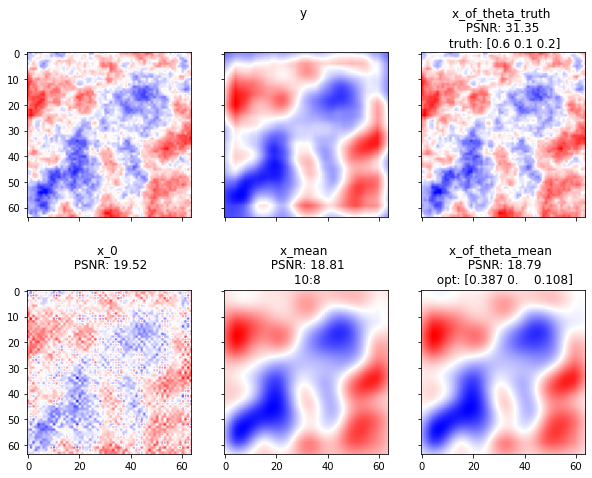

In [18]:
N,use_sample_size = np.array([100,80])//10 # total smaple number, burn-in number??
show_step = 100
for theta_truth in thetas_truth:
    x_truth, y,T_pr_truth,T_obs_inv,mus = gen_tests_of_deblur(theta_truth,hypers,M=1)
    theta_mean,theta_var,x_mean,x_var = Gibbs_sample(N,use_sample_size,x_truth,y,T_obs_inv,hypers,show_step=show_step,theta_truth=theta_truth)

# 测试真实图片

In [19]:
from skimage.data import camera
from skimage import data,img_as_float
from skimage.transform import resize
from numpy import random

image = img_as_float(data.camera())   #??
img = resize(image,(hypers['image_size'],hypers['image_size']))
print(img.mean(),img.std())
# plt.imshow(image, cmap=plt.cm.gray)

x_truth = img.reshape(-1,1)
y_without_noise = hypers['G']@x_truth

sigma = hypers['noise_signal_ratio'] * x_truth.max()
T_obs_inv = np.diag([1/sigma**2]*hypers['x_dim'])
random.seed(5)
b = np.random.randn(*y_without_noise.shape) * sigma

y = y_without_noise+b

0.4639797450125705 0.22523049037323803


## sampling

 29%|██▊       | 2/7 [00:09<00:22,  4.48s/it]

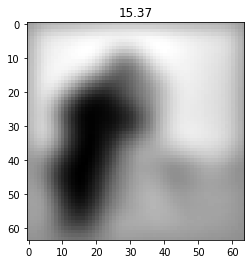

 43%|████▎     | 3/7 [00:20<00:30,  7.52s/it]

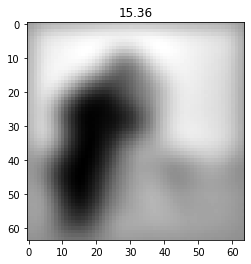

 57%|█████▋    | 4/7 [00:29<00:23,  7.99s/it]

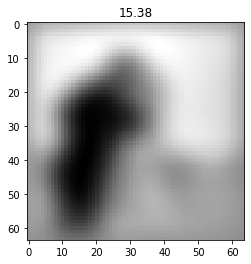

 71%|███████▏  | 5/7 [00:32<00:12,  6.32s/it]

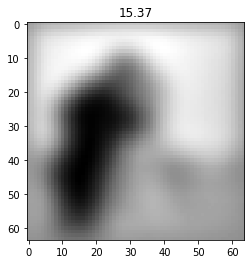

 86%|████████▌ | 6/7 [00:37<00:05,  5.91s/it]

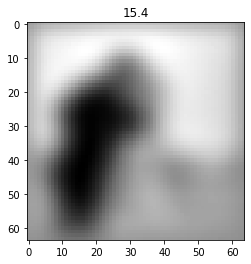

100%|██████████| 7/7 [00:41<00:00,  5.87s/it]
/public/home/hpc220115/zqp/hyperpara_optim_dnn-main/utils.py:248: RuntimeWarning: invalid value encountered in true_divide
  ground_truth = (ground_truth - ground_truth.min()) / (ground_truth.max() - ground_truth.min())


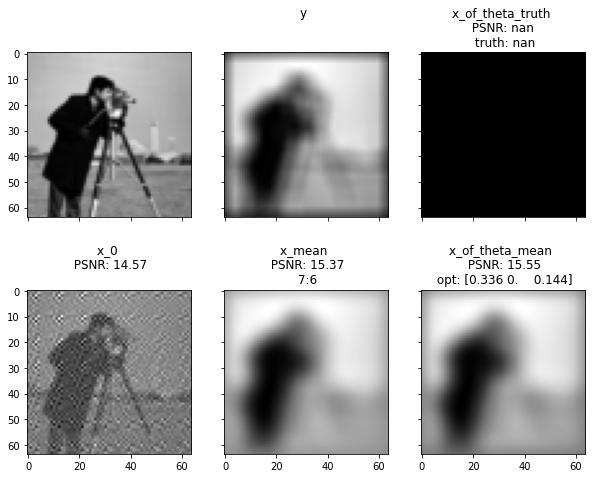

In [21]:
N,use_sample_size,show_step = np.array([7500,6000,1000])//1000  #??
hypers['cmap'] ='gray'
theta_mean_people,theta_var_people,x_mean_people,x_var_people = Gibbs_sample(N,use_sample_size,x_truth,y,T_obs_inv,hypers,show_step=show_step,theta_truth=None)

## deblur using Gaussian prior

In [21]:
theta_0 = [0.5,0.035,0.228]
mus,T_pr = prior_mean_cov(theta_0,hypers)

A = hypers['G']
n,m = hypers['data_dim'],hypers['x_dim']

# Construct the problem.
gamma = cp.Parameter(nonneg=True)
x = cp.Variable(m)
f = cp.sum_squares(A@x - y.flatten())/sigma**2 + cp.multiply(gamma,cp.matrix_frac(x-mus.flatten(), T_pr)/2)

# constraints = [0<=x,x<=1]         
objective = cp.Minimize(f)
# p = cp.Problem(objective,constraints)
p = cp.Problem(objective)

# Assign a value to gamma and find the optimal x.
def deblur_with_tv_penalty(gamma_value):
    gamma.value = gamma_value
    result = p.solve(solver=cp.SCS)
    return x.value

gammas = np.arange(0.5,5,0.5).round(3).tolist()
parallel_nodes = len(gammas)
pool = Pool(processes = parallel_nodes)
par_x = pool.map(deblur_with_tv_penalty, gammas)

Process ForkPoolWorker-75:
Process ForkPoolWorker-74:
Process ForkPoolWorker-77:
Process ForkPoolWorker-72:
Process ForkPoolWorker-70:
Process ForkPoolWorker-69:
Process ForkPoolWorker-71:
Process ForkPoolWorker-76:
Process ForkPoolWorker-73:
Traceback (most recent call last):
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/p

lambda^*:1.0, PSNR_max: 26.57


<Figure size 1440x360 with 0 Axes>

Text(0.5, 0, 'lambda')

Text(0, 0.5, 'PSNR')

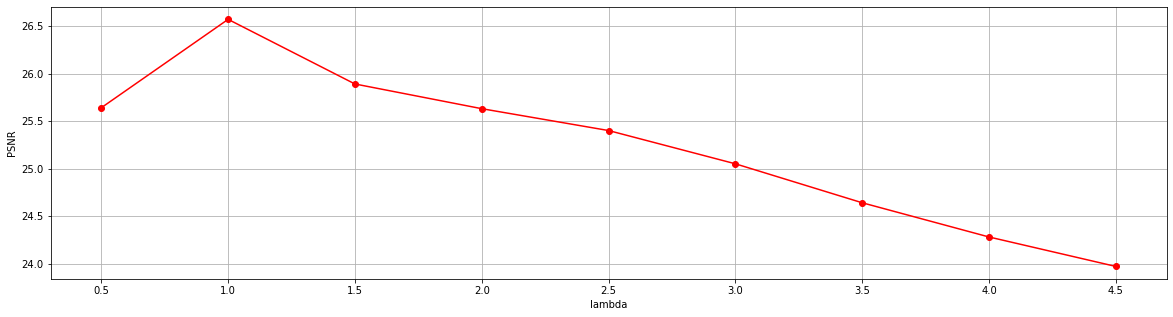

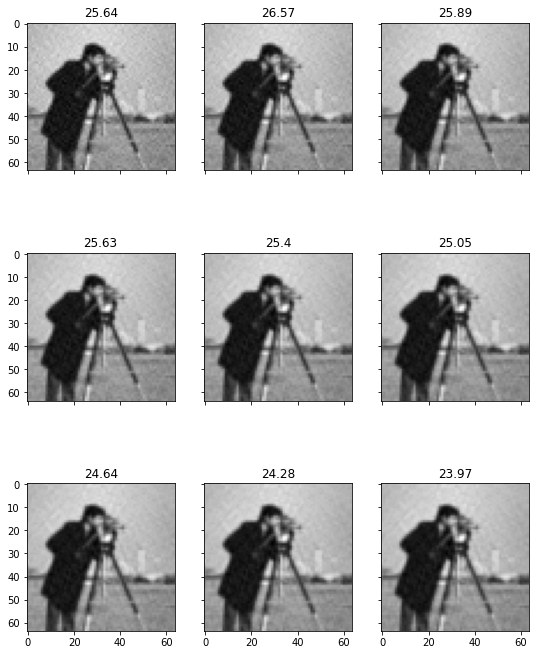

In [24]:
imgs_rec = [xi.reshape(hypers['image_size'],hypers['image_size']) for xi in par_x]
psnrs= [PSNR(img_rec,img) for img_rec in imgs_rec]
lambda_star = gammas[np.argmax(psnrs)]
psnr_start = np.max(psnrs)
print(f'lambda^*:{lambda_star}, PSNR_max: {psnr_start}')

plt.figure(figsize=(20,5))
plt.plot(gammas,psnrs,'ro-')
plt.xlabel('lambda')
plt.ylabel('PSNR')
plt.grid()

n_col = 3
n_row = int(len(gammas)/n_col)

show_images(imgs_rec,titles=[str(psnr) for psnr in psnrs],
            shape=(n_row,n_col),figsize=(n_col*3, n_row*4),cmap='gray')

## deblur using TV prior

lambda^*:4.452, PSNR_max: 27.67


<Figure size 1440x360 with 0 Axes>

(24.0, 32.0)

Text(0.5, 0, 'lambda')

Text(0, 0.5, 'PSNR')

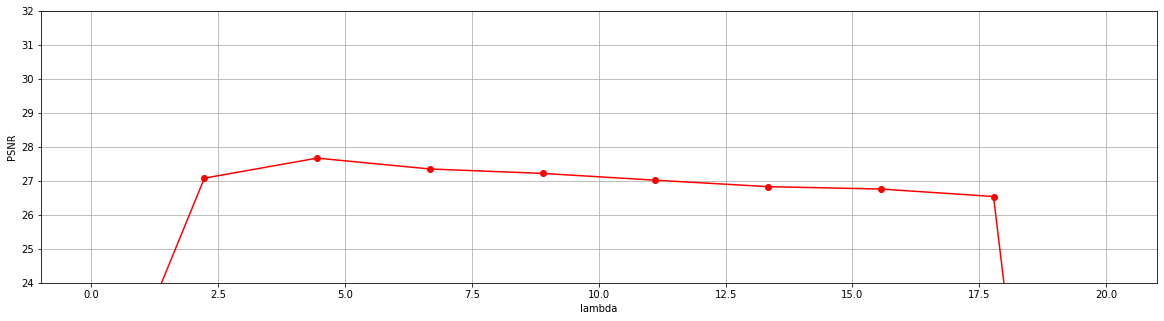

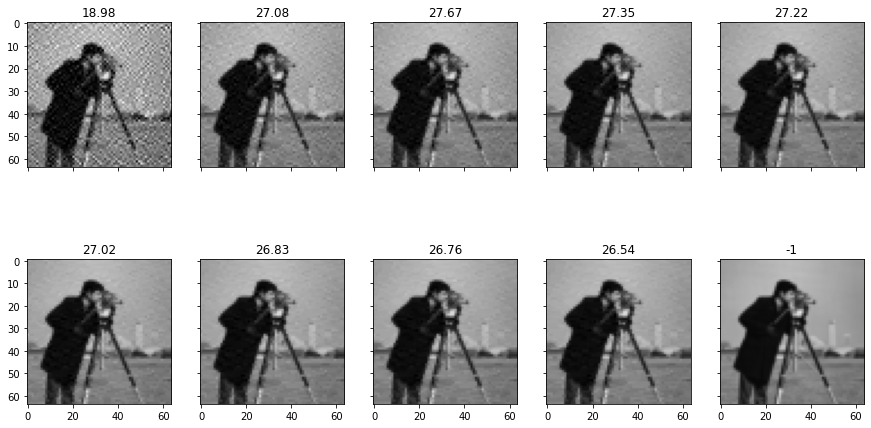

Process ForkPoolWorker-59:
Process ForkPoolWorker-63:
Process ForkPoolWorker-68:
Process ForkPoolWorker-62:
Process ForkPoolWorker-67:
Process ForkPoolWorker-64:
Process ForkPoolWorker-61:
Process ForkPoolWorker-65:
Process ForkPoolWorker-60:
Process ForkPoolWorker-66:
Traceback (most recent call last):
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/public/home/hpc220115/.conda/envs/dlenv/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_

In [20]:
A = hypers['G']
n,m = hypers['data_dim'],hypers['x_dim']

# Construct the problem.
gamma = cp.Parameter(nonneg=True)
x = cp.Variable(m)
f = cp.sum_squares(A@x - y.flatten())/(2*sigma**2) + cp.multiply(gamma,cp.tv(x))

constraints = [0<=x,x<=1]         
objective = cp.Minimize(f)
p = cp.Problem(objective,constraints)

# Assign a value to gamma and find the optimal x.
def deblur_with_tv_penalty(gamma_value):
    gamma.value = gamma_value
    result = p.solve(solver=cp.SCS)
    return x.value

gammas = np.linspace(0.01,20,10).round(3).tolist()
parallel_nodes = 10
pool = Pool(processes = parallel_nodes)
par_x = pool.map(deblur_with_tv_penalty, gammas)

imgs_rec = [xi.reshape(hypers['image_size'],hypers['image_size']) for xi in par_x]
imgs_rec[-1] = img # 最后一个是真实图像
psnrs= [PSNR(img_rec,img) for img_rec in imgs_rec]
lambda_star = gammas[np.argmax(psnrs)]
psnr_start = np.max(psnrs)
print(f'lambda^*:{lambda_star}, PSNR_max: {psnr_start}')

plt.figure(figsize=(20,5))
plt.plot((gammas),psnrs,'ro-')
plt.ylim([24,32])
plt.xlabel('lambda')
plt.ylabel('PSNR')
plt.grid()

n_col = 5
n_row = int(len(gammas)/n_col)

show_images(imgs_rec,titles=[str(psnr) for psnr in psnrs],
            shape=(n_row,n_col),figsize=(n_col*3, n_row*4),cmap='gray')

# 产生一个样本

In [ ]:
def gen_one_para_samples(theta, hypers=hypers):
    """
    x = N(u,C)
    y = Poisson(x*noise_level)/nosie_level

        Parameters
        ----------
             theta: [mu,gamma,d]
            hypers:

        Returns
            thetas, xs, ys:  [M,dim]
        -------

    """
    G = hypers['G']
    M = hypers['M_samples_per_para']
    x_dim = hypers['x_dim']
    mu, gamma, d = theta

    C = prior_cov(hypers['distM'], gamma=gamma, d=d)
    xs = np.random.multivariate_normal([mu] * x_dim, C, M)  # [M,dim]

    sigmas = hypers['noise_signal_ratio'] * xs.max(axis=1)
    b = np.random.randn(*xs.shape) * sigmas.reshape(-1, 1)
    ys = xs@G.T + b  # broadcasting    (M,x_dim)+(M,1)
    return np.array([theta] * M), xs, ys

In [ ]:
%run problem_setting.py

In [ ]:
thetas,xs,ys = gen_one_para_samples([0.4,0.3,10/48], hypers=hypers)

from visualize import show_images
index_start,index_end = 10,13
xs_img = [x.reshape(hypers['image_size'],hypers['image_size']) for x in xs[index_start:index_end,:]]
ys_img = [x.reshape(hypers['image_size'],hypers['image_size']) for x in ys[index_start:index_end,:]]
show_images(xs_img)
show_images(ys_img)
